In [1]:
from core.metrics import *
from core.semcor_bert_pipeline import load_data, get_pos
from core.analysis import *
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import pandas as pd

<Figure size 432x288 with 0 Axes>

## MDS on Centroids of Shared Words

In [2]:
shared_words = ['foot', 'table', 'plane', 'degree', 'right', 'model']
db = access_db() #Some senses that were logged were not used in expt

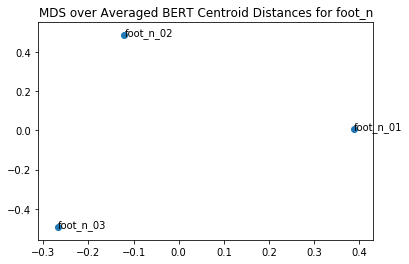

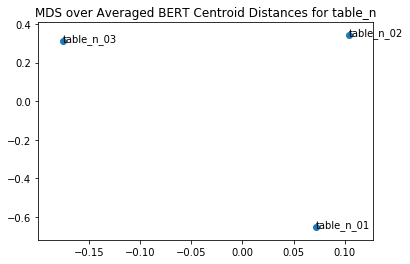

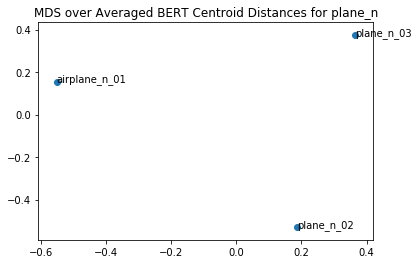

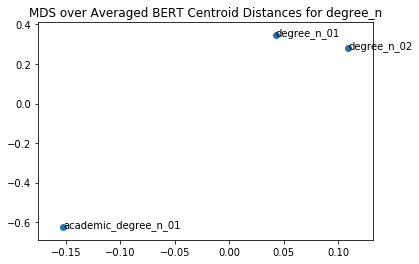

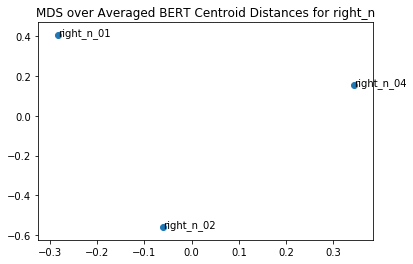

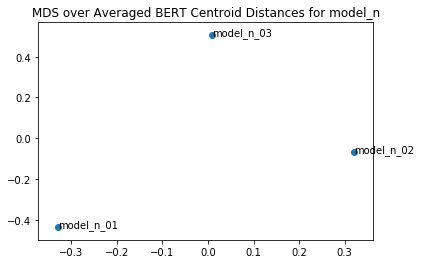

In [3]:
for w in shared_words:
    result_mtx, sense_names = cosine_sim_mtx(w, 'n',sel_senses = [fb_to_local(s) for s in get_senses(db, w + "_n")],
                                            use_masc = True, normalize = True)
    mds_model = MDS(n_components = 2, dissimilarity = 'precomputed')
    plot_mds(result_mtx, w + '_n', mds_model, db, "BERT Centroid")

## Comparison with Experiment Results

In [4]:
results, corrs = get_results_users(db)
min_time = corrs.drop('userID', axis = 1).apply(np.mean)['timeTaken'] - corrs.drop('userID', axis = 1).apply(np.std)['timeTaken']
incl_users = corrs[(corrs['timeTaken'] > min_time) & ((corrs['Group Consistency'] > 0.4) & (corrs['Self Consistency'] > 0.2))]['userID']
incl_users = incl_users.tolist()

/Users/sathvik/Desktop/Berkeley/Research/thesis/codebase/core/analysis.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['changes'] = user_changes['prevChanged'].values


Spearman Rank correlations for BERT embeddings for shared words vs. human data. Averages distances reported from experimental data reported below for comparison. 

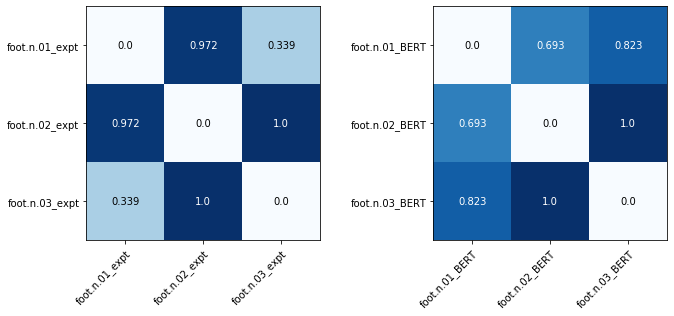

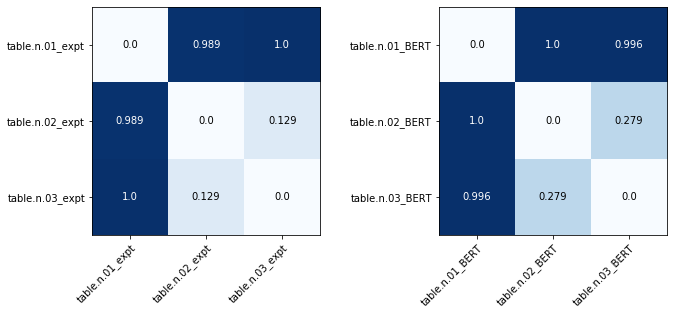

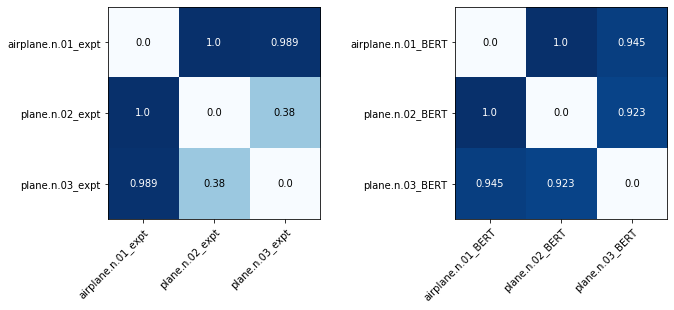

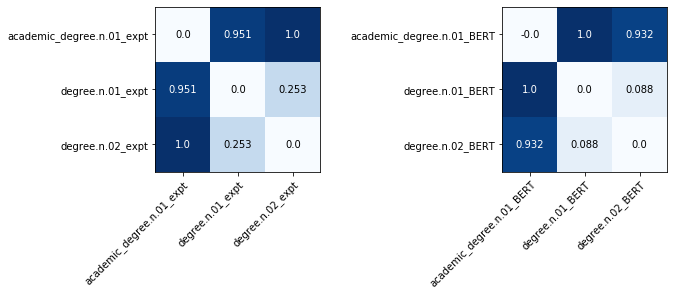

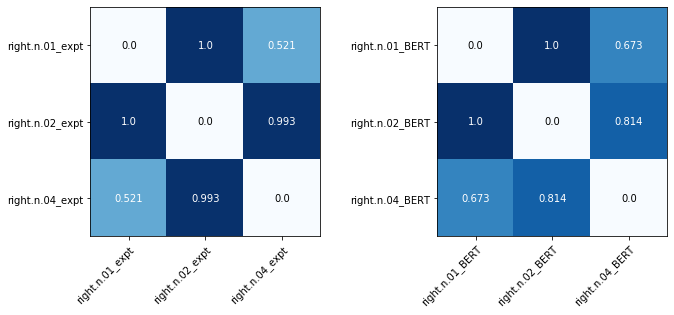

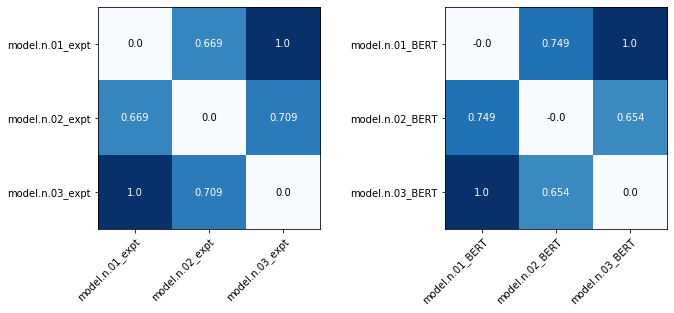

In [5]:
shared_words = ['foot_n', 'table_n', 'plane_n', 'degree_n', 'right_n', 'model_n']
matrices = {w: {} for w in shared_words}

#print("Spearman Rank Correlations for Shared Words")
for w in shared_words:
    expt_means = mean_distance_mtx(results, w, 'shared', incl_users, normalize = True)
    matrices[w]['expt'] = expt_means
    word, pos = w.split("_")
    bert_cs, sense_names = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                          use_masc = True)
    bert_cs = normalize_cos_dist(bert_cs)
    matrices[w]['bert'] = bert_cs
    #print(w, mtx_correlation([matrices[w]['bert']], [matrices[w]['expt']]))
    fig = plt.figure(figsize = (10, 10))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    im1 = ax1.imshow(expt_means)
    annotate_mtx(expt_means, im1, ax1, [s + "_expt" for s in sense_names])
    im2 = ax2.imshow(bert_cs)
    annotate_mtx(bert_cs, im2, ax2, [s + '_BERT' for s in sense_names])
    fig.tight_layout(pad = 3.0)


In [6]:
all_human_avg = [matrices[w]['expt'] for w in shared_words]
all_bert_cs = [matrices[w]['bert'] for w in shared_words]
bert_human_shared = mtx_correlation(all_human_avg, all_bert_cs, method = 'pearson')
bert_human_shared

0.7580770320547892

In [7]:
import seaborn as sns

Text(0.5, 0, "Pearson's R")

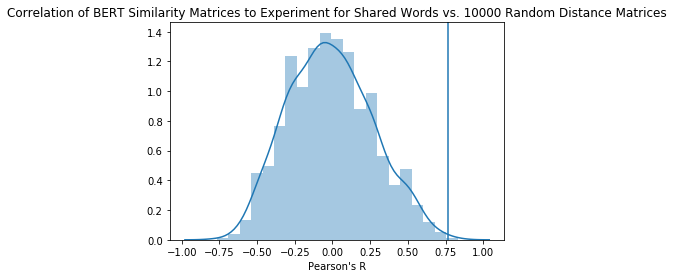

In [11]:
random_vs_human = [mtx_correlation([create_random_symmetric_mtx() for i in range(len(shared_words))],
                          all_human_avg, method = 'pearson') for i in range(1000)]
sns.distplot(random_vs_human)
plt.axvline(bert_human_shared)
plt.title("Correlation of BERT Similarity Matrices to Experiment for Shared Words vs. 10000 Random Distance Matrices")
plt.xlabel("Pearson's R")

Text(0.5, 0, "Pearson's R")

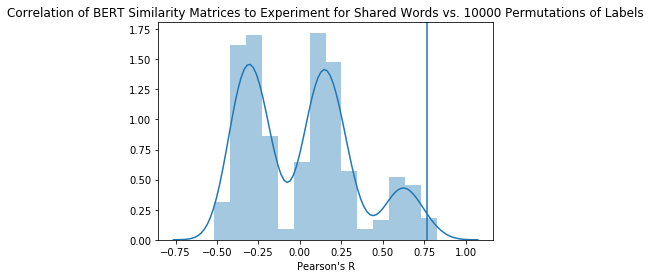

In [12]:
permuted_bert_entries = [mtx_correlation(all_bert_cs, all_human_avg,
                                         method = 'pearson', randomize_m1_labels = True) for i in range(1000)]
sns.distplot(permuted_bert_entries)
plt.axvline(bert_human_shared)
plt.title("Correlation of BERT Similarity Matrices to Experiment for Shared Words vs. 10000 Permutations of Labels")
plt.xlabel("Pearson's R")

## Full Experiment Results

We find how many subjects have provided data for each type

In [8]:
lemma_counts = get_lemma_counts(results, incl_users, db)

In [9]:
lemma_counts

,lemma,num_trials
0,door_n,26.0
1,time_n,22.0
2,world_n,22.0
3,case_n,21.0
4,area_n,20.0
5,consider_v,20.0
6,face_n,20.0
7,indicate_v,20.0
8,heart_n,19.0
9,life_n,19.0


We consider words that have been showed more than 7 times, and populate our dictionary of matrices with their information

In [19]:
def get_test_result_data(results, w, incl_users):
    test_means = mean_distance_mtx(results, w, 'test', incl_users, normalize = True)
    repeat_means = mean_distance_mtx(results, w, 'repeat', incl_users, normalize = True)
    expt_means = test_means
    if repeat_means.shape:
        expt_means = np.mean([test_means, repeat_means], axis = 0)
        expt_means /= np.max(expt_means)
    return expt_means

In [20]:
test_repeat_words = lemma_counts[lemma_counts['num_trials'] > 12]['lemma']
for w in test_repeat_words:
    matrices[w] = {}
    word, pos = w.split('_')
    cs_mtx, _ = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                                    use_masc = True, normalize = True)
    matrices[w]['bert'] = cs_mtx
    matrices[w]['expt'] = get_test_result_data(results, w, incl_users)


In [22]:
all_human_avg = [matrices[w]['expt'] for w in matrices.keys()]
all_bert_cs = [matrices[w]['bert'] for w in matrices.keys()]
bert_human_all = mtx_correlation(all_human_avg, all_bert_cs, method = 'pearson')
bert_human_all

0.5099540908067091

Text(0.5, 0, "Pearson's R")

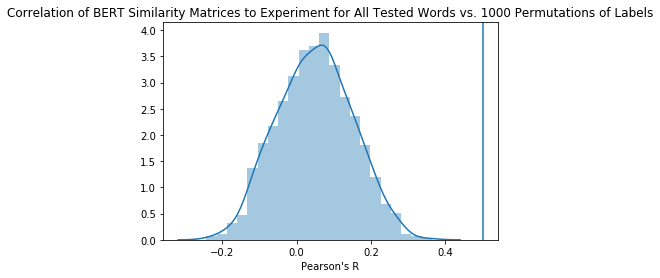

In [47]:
permuted_bert_entries = [mtx_correlation(all_bert_cs, all_human_avg,
                                         method = 'pearson', randomize_m1_labels = True) for i in range(1000)]
sns.distplot(permuted_bert_entries)
plt.axvline(bert_human_all)
plt.title("Correlation of BERT Similarity Matrices to Experiment for All Tested Words vs. 1000 Permutations of Labels")
plt.xlabel("Pearson's R")

In [48]:
all_words = test_repeat_words.tolist() + results[results['trialType'] == 'shared']['lemma'].unique().tolist()

Text(0.5, 0, "Pearson's R")

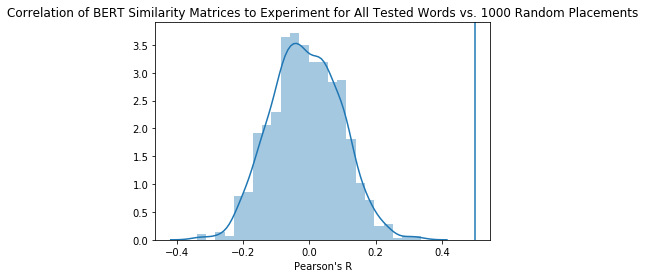

In [49]:
permuted_bert_entries = [mtx_correlation([create_random_symmetric_mtx(get_num_senses(w, db)) for w in all_words], 
                                         all_human_avg,
                                         method = 'pearson') for i in range(1000)]


sns.distplot(permuted_bert_entries)
plt.axvline(bert_human_all)
plt.title("Correlation of BERT Similarity Matrices to Experiment for All Tested Words vs. 1000 Random Placements")
plt.xlabel("Pearson's R")

## Bootstrapping Shared Data

Seeing if around 10 subjects' results is good enough of a comparison to the BERT embeddings.

In [63]:
results

,trialID,userID,trialIndex,trialType,prevChanged,lemma,sense,x,y
206,-M3pVhmrS4LVzC6_gIcJ,-M3pVTw9ili6muvdZKg4,1,training,1,bank_n,bank_n_01,173.0,360.0
207,-M3pVhmrS4LVzC6_gIcJ,-M3pVTw9ili6muvdZKg4,1,training,1,bank_n,bank_n_05,614.0,362.0
208,-M3pVhmrS4LVzC6_gIcJ,-M3pVTw9ili6muvdZKg4,1,training,1,bank_n,depository_financial_institution_n_01,499.0,368.0
209,-M3pVmug0DJj2iajKInK,-M3pVTw9ili6muvdZKg4,2,training,0,bass_n,bass_n_03,241.0,402.0
210,-M3pVmug0DJj2iajKInK,-M3pVTw9ili6muvdZKg4,2,training,0,bass_n,bass_n_04,723.0,324.0
...,...,...,...,...,...,...,...,...,...
2879,-M5qVu-sNZwiuvd4Muun,-M5qRUAC0NSqqlOSnBvy,18,repeat,0,cover_v,cover_v_01,360.0,322.0
2880,-M5qVu-sNZwiuvd4Muun,-M5qRUAC0NSqqlOSnBvy,18,repeat,0,cover_v,cover_v_02,555.0,377.0
2881,-M5qVu-sNZwiuvd4Muun,-M5qRUAC0NSqqlOSnBvy,18,repeat,0,cover_v,cover_v_03,300.0,405.0
2882,-M5qVu-sNZwiuvd4Muun,-M5qRUAC0NSqqlOSnBvy,18,repeat,0,cover_v,cover_v_04,340.0,330.0


In [70]:
bootstrapped_corrs = [sample_from_shared(results, incl_users, matrices, sample_size = 13) for _ in np.arange(1000)]

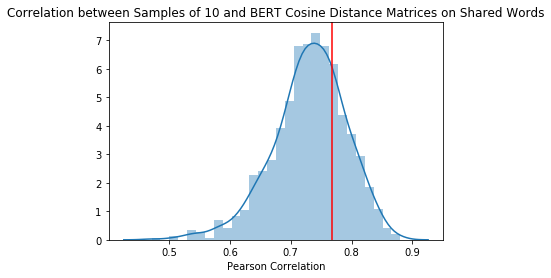

In [67]:
sns.distplot(bootstrapped_corrs)
plt.xlabel("Pearson Correlation")
plt.title("Correlation between Samples of 10 and BERT Cosine Distance Matrices on Shared Words")
plt.axvline(bert_human_shared, color = 'red')

In [68]:
(np.percentile(bootstrapped_corrs, 2.5), np.percentile(bootstrapped_corrs, 97.5))

(0.5917274139545625, 0.8361350644248275)

## Within-Word Consistency

In [214]:
import itertools

In [278]:
%%time
avg_pairwise_corr = {}
trial_types = ['test', 'repeat', 'shared']
for w in all_words:
    users = results[results['lemma'] == w]['userID']
    word_results = []
    for u in users:
        for t in trial_types:
            subject_results, _ = get_subject_mtx(results, u, w, t)
            if len(subject_results):
                word_results.append(subject_results)
    combs = list(itertools.combinations(word_results, 2))
    i1 = [i[0] for i in combs]
    i2 = [i[1] for i in combs]
    avg_pairwise_corr[w] = mtx_correlation(i1, i2)


CPU times: user 19.3 s, sys: 72.7 ms, total: 19.4 s
Wall time: 19.5 s


In [301]:
pwc = pd.DataFrame(avg_pairwise_corr.values(), index=avg_pairwise_corr.keys(),
                                 columns = ['avg_pairwise_corr'])
pwc = pwc_test.reset_index()
pwc.drop('index', axis = 1, inplace = True)

Average pairwise correlation of high entropy words

In [302]:
with_entropy = pwc.merge(semcor_entropy, on = 'lemma')
np.mean(with_entropy[with_entropy['entropy'] > 1.45]['avg_pairwise_corr'])

0.25696816636623593

Low Entropy words

In [303]:
np.mean(with_entropy[with_entropy['entropy'] < 1.45]['avg_pairwise_corr'])

0.40148198094938303

Text(0.5, 1.0, 'Average Pairwise Spearman Correlation Between Subjects')

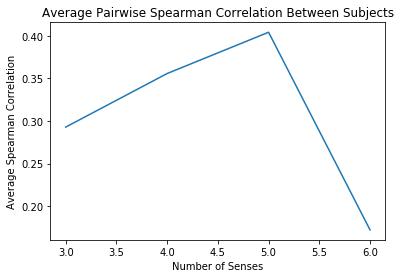

In [308]:
pwc['pos'] = pwc['lemma'].apply(get_pos, args = '_')
pwc['num_senses'] = pwc['lemma'].apply(get_num_senses, args = [db])
plt.plot(range(3, 7), [np.mean(pwc[pwc['num_senses'] == i]['avg_pairwise_corr']) for i in range(3, 7)])
plt.xlabel("Number of Senses")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Pairwise Spearman Correlation Between Subjects")

In [310]:
np.mean(pwc[pwc['pos'] == 'n']['avg_pairwise_corr'])

0.31649445327512277

In [311]:
np.mean(pwc[pwc['pos'] == 'v']['avg_pairwise_corr'])

0.3054616301024531